# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse
import random

from scipy import stats
from random import sample

# Connect to database

In [9]:
# connect = {'host':'https://clickhouse.lab.karpov.courses',
#            'password':'dpo_python_2020',
#            'user':'student',
#            'database':'simulator_20240120'}

# query = """select exp_group,
#                   user_id,
#                   sum(action = 'view') as views,
#                   sum(action = 'like') as likes,
#                   round(likes * 100/views, 2) as ctr
#             from simulator_20240120.feed_actions
#             where (toDate(time) >= '2023-12-22' and toDate(time) <= '2023-12-28') and exp_group in(2,3)
#             group by exp_group, user_id"""


# df = pandahouse.read_clickhouse(query, connection=connect)

# # save frame
# df.to_csv('data/AA_test.csv', index=False)

In [11]:
# save frame
df = pd.read_csv('data/AA_test.csv')
df.head(3)

,exp_group,user_id,views,likes,ctr
0,3,115383,248,38,15.32
1,3,10326,132,24,18.18
2,3,123580,122,25,20.49


# 10 000 А/А-tests simulations

 А/А-test: from 2023-12-22 to 2023-12-28

In [5]:
# count p-value t-test 10 000 iter.
users_gr2 = sorted(df[df['exp_group'] == 2]['user_id'])
users_gr3 = sorted(df[df['exp_group'] == 3]['user_id'])
ttest_pvalues_list = []

for i in range(0,10000):
    
    # randomly sample values from 2 and 3 groups by 500 users (non repeating)
    group2 = random.sample(users_gr2, 500)
    group3 = random.sample(users_gr2, 500)
    
    # split check
    if len(set(group2)) == len(set(group3)):
        
        # get 2 frames from 2 and 3 groups include random users and ctr's
        group2_df = pd.DataFrame(group2, columns=['user_id']).join(df[['user_id', 'ctr']].set_index('user_id'), on='user_id')
        group3_df = pd.DataFrame(group3, columns=['user_id']).join(df[['user_id', 'ctr']].set_index('user_id'), on='user_id')

        # ttest
        ttest_pvalue = stats.ttest_ind(group2_df['ctr'], group3_df['ctr'], equal_var=False)[1] 
        ttest_pvalues_list.append(ttest_pvalue)
        
    else:
        print('Error')
        break

Количество проведенных тестов: 10000


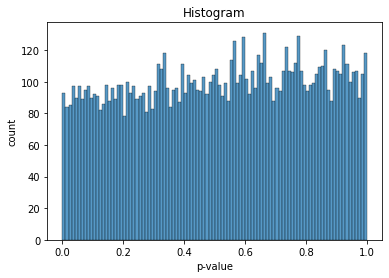

In [13]:
# distributions histogram ttest_pvalue

print('Ttests simulations count:', len(ttest_pvalues_list))

ax = sns.histplot(data=ttest_pvalues_list, bins=100)
ax.set(xlabel='p-value', ylabel='count')
ax.set_title('Histogram')
plt.show()

In [12]:
# how much p-value samples <= 0.05

percentage = sum(pd.DataFrame(ttest_pvalues_list, columns=['pvalue'])['pvalue'] <= 0.05)*100 / 10000
print('Share of pvalue with values <= 0.05:', percentage, '%')

Доля pvalue, значение которых <= 0.05: 4.49 %


# Conclusion:

The p-values in the T-test are uniform distributions. The probability of getting any p-values in once ttest has 1/N possibility.

In our case, just 4.5% of 10 000 test show values lowest than 0.05.

We can conclude that 2 and 3 groups have not statistically difference by main metric.